In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.data.feature import annodata as data_anndata
from src.data.feature import target   as data_target
from src.io           import loader   as data_loader
from src.io           import writer   as data_writer

# 1. Setup

In [3]:
# Setup some directory paths

OUT_SUBFOLDER = 'nbp05-target'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_DATA  = os.path.join(OUT, 'data',  OUT_SUBFOLDER)
OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_NBP02 = os.path.join(OUT, 'data',  'nbp02-anndata')

shutil.rmtree(OUT_DATA, ignore_errors = True)
shutil.rmtree(OUT_PLOT, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Load the annotated and cleaned data

anndata = data_loader.load_h5ad(
	filename = os.path.join(RES_NBP02, 'arabidopsis-r36.h5ad')
)

# 2. Regression

In [5]:
# Extract the transcript tpm values

values, order = data_target.extract_tpm_multi(
	data      = anndata,
	layer     = 'boxcox1p',
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
	functions = [
		('max',  lambda x : numpy.max(x, axis = 0)),
		('p80',  lambda x : numpy.percentile(x, 80, axis = 0)),
		('mean', lambda x : numpy.mean(x, axis = 0)),
		('std',  lambda x : numpy.std(x, axis = 0))
	]
)

In [6]:
# Display an example of the transcript tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:5.3f}'.format(x) for x in value))

tissue-max        : [ 8] 2.237 2.752 2.199 2.871 2.617 2.798 2.612 1.030
tissue-p80        : [ 8] 1.755 1.691 1.709 2.411 1.652 2.015 2.111 0.412
tissue-mean       : [ 8] 1.539 1.279 1.164 2.157 1.437 1.679 1.473 0.294
tissue-std        : [ 8] 0.251 0.499 0.619 0.391 0.393 0.402 0.871 0.269
age-max           : [ 5] 2.773 2.752 1.839 2.612 2.871
age-p80           : [ 5] 1.959 2.122 1.594 2.026 2.287
age-mean          : [ 5] 1.488 1.661 1.378 1.038 1.873
age-std           : [ 5] 0.533 0.448 0.230 0.910 0.434
group-max         : [19] 2.237 2.689 2.199 2.766 1.567 2.773 1.638 2.752 2.215 1.770 1.839 2.612 1.030 1.752 2.013 1.183 2.871 2.617 2.798
group-p80         : [19] 1.833 1.626 1.711 2.423 1.455 1.953 1.532 2.185 2.124 1.664 1.594 2.111 0.412 1.737 1.740 1.177 2.415 2.273 2.137
group-mean        : [19] 1.563 1.240 1.163 2.184 1.219 1.641 1.439 1.752 1.691 1.306 1.378 1.473 0.294 1.713 1.621 1.168 2.166 1.919 1.752
group-std         : [19] 0.276 0.485 0.648 0.408 0.300 0.387 0.100 0.45

## 2.1 Distributions

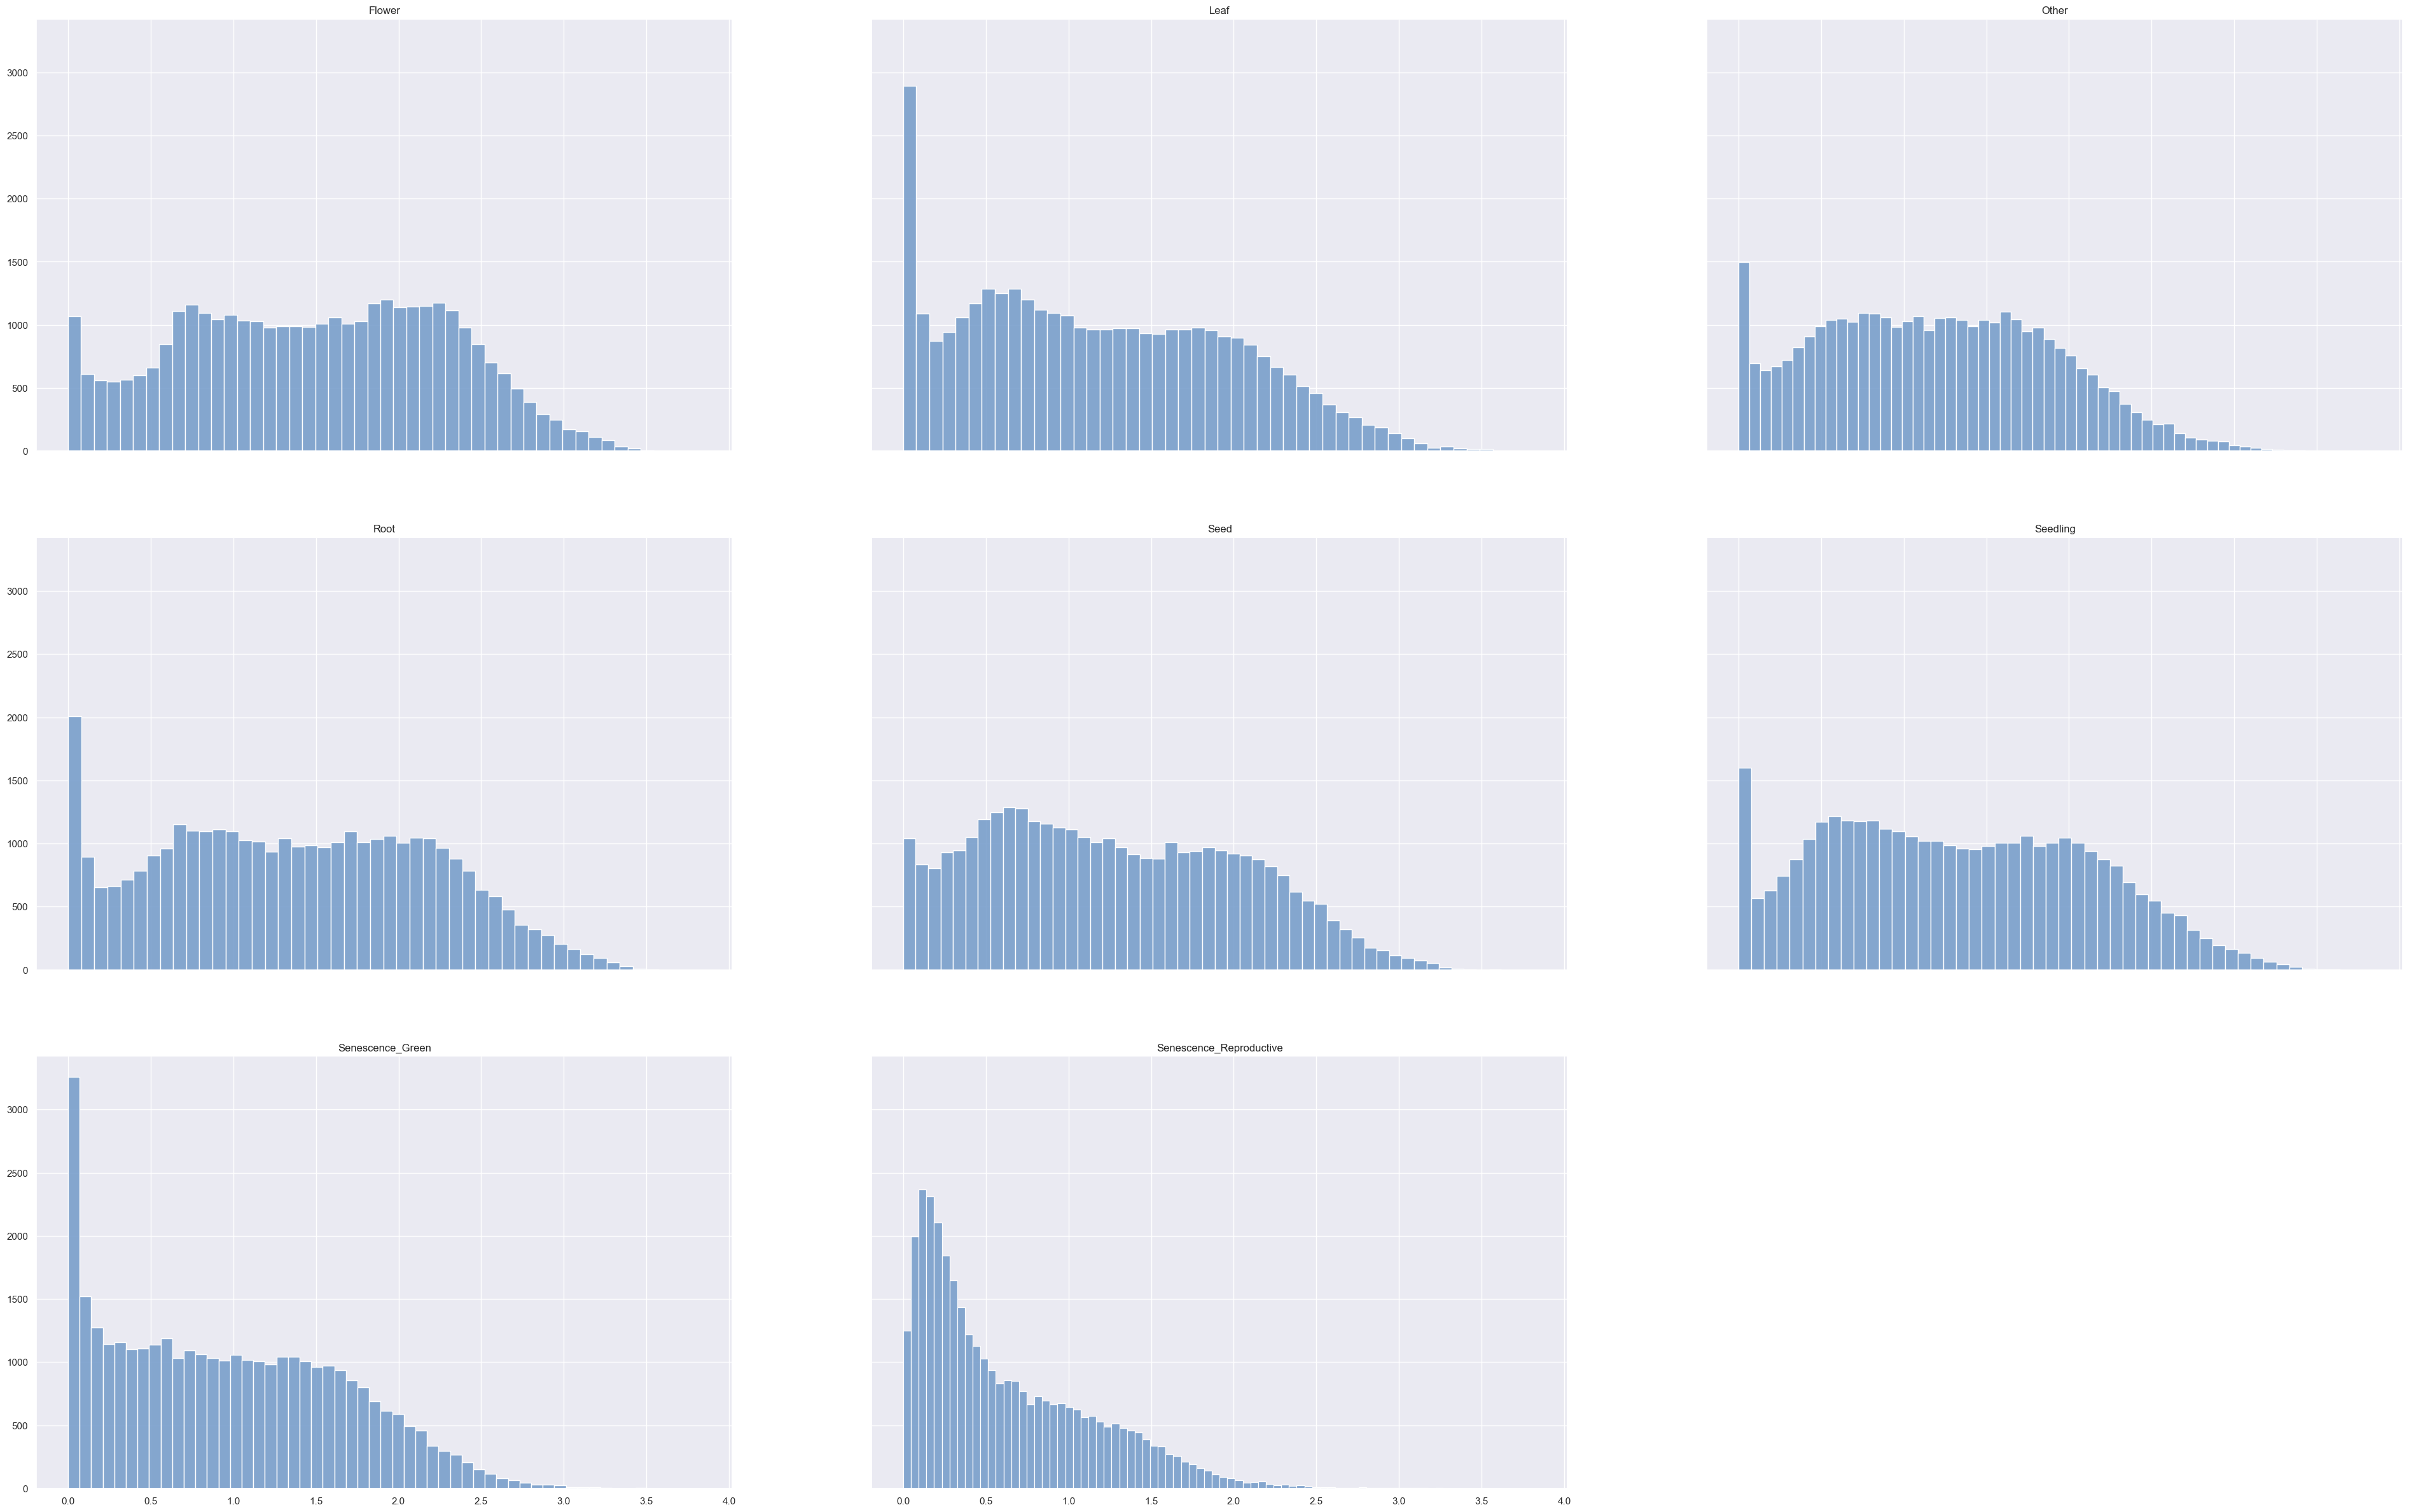

In [7]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-mean')
)

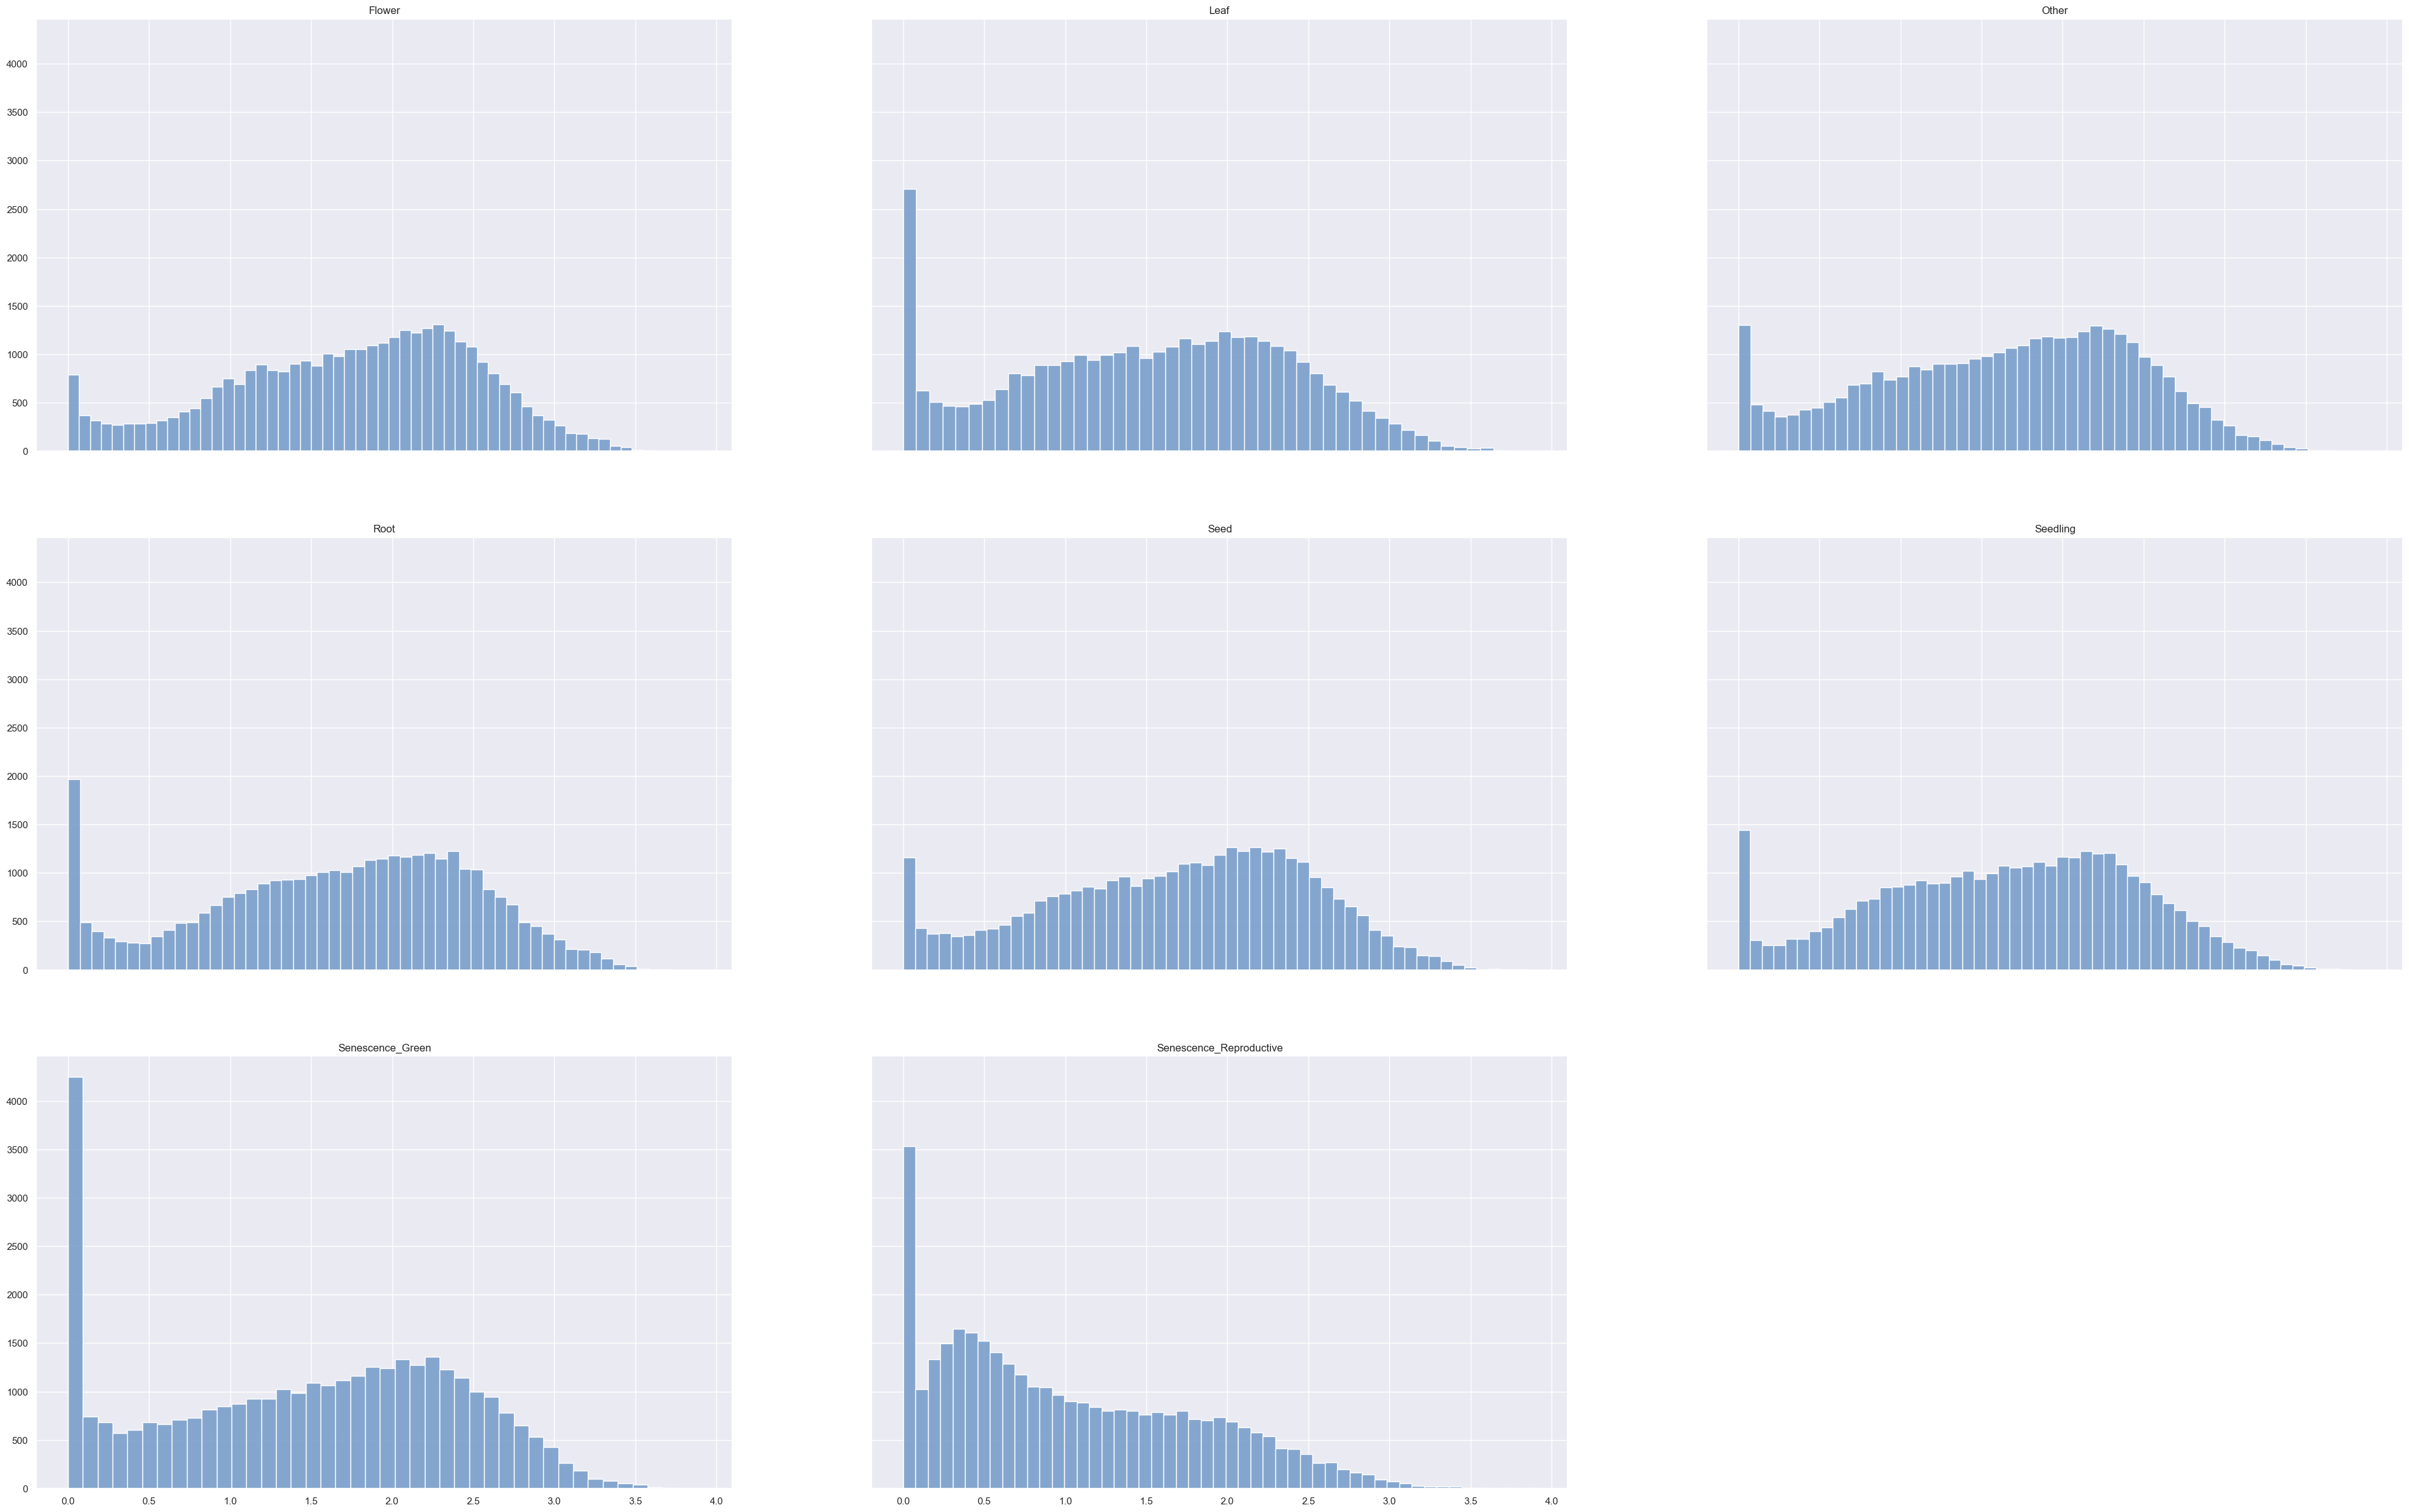

In [8]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'p80',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-p80')
)

## 2.2 Save

In [9]:
# Save the target transcript tpm values

data_writer.write_json(
	data     = values,
	filename = os.path.join(OUT_DATA, 'target-values.json')
)

data_writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. Classification

In [10]:
# Extract the transcript tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = data_target.classify_tpm(
	data    = values,
	classes = 10
)

In [11]:
# Display bounds in different configurations (start, values and mapping are manually set based on nbp02-anndata)

data_target.display_bounds_mapping(
	bounds     = bounds['tissue-mean'],
	start      = 'boxcox1p',
	values = {
		'min_value'  :  0.0,
		'max_value'  :  3.9823754592208442,
		'box_lambda' : -0.2405820974347097,
		'log_base'   :  2
	},
	mapping = {
		'log1p'    : None,
		'boxcox1p' : None,
		'normal'   : 'boxcox1p',
		'standard' : 'boxcox1p'
	}
)

                             boxcox1p |                           tpm
---------------------------------------------------------------------
level-0       0.00000 -       0.16383 |       0.00000 -       0.18193
level-1       0.16383 -       0.40309 |       0.18193 -       0.52806
level-2       0.40309 -       0.63350 |       0.52806 -       0.98837
level-3       0.63350 -       0.85765 |       0.98837 -       1.61317
level-4       0.85765 -       1.10010 |       1.61317 -       2.58893
level-5       1.10010 -       1.36185 |       2.58893 -       4.20692
level-6       1.36185 -       1.63800 |       4.20692 -       7.02402
level-7       1.63800 -       1.92793 |       7.02402 -      12.34029
level-8       1.92793 -       2.27357 |      12.34029 -      25.87707
level-9       2.27357 -       3.82832 |      25.87707 -  38,251.95003


In [12]:
# Display an example of the transcript classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 8] 5 7 4 8 7 8 7 0
tissue-p80        : [ 8] 5 5 5 8 5 6 7 1
tissue-mean       : [ 8] 6 5 5 8 6 7 6 1
age-max           : [ 5] 7 7 2 6 8
age-p80           : [ 5] 6 6 4 6 7
age-mean          : [ 5] 6 7 5 4 7
group-max         : [19] 5 8 5 8 2 8 3 8 5 3 3 7 1 3 4 1 8 7 8
group-p80         : [19] 5 4 5 8 4 6 4 7 6 5 4 6 1 5 5 3 8 7 7
group-mean        : [19] 6 4 4 8 4 6 5 6 6 5 5 5 1 6 6 4 8 7 6
perturbation-max  : [ 8] 8 7 5 7 6 6 6 6
perturbation-p80  : [ 8] 7 6 7 6 5 5 6 6
perturbation-mean : [ 8] 7 6 8 6 5 5 4 6


## 3.1 Distributions

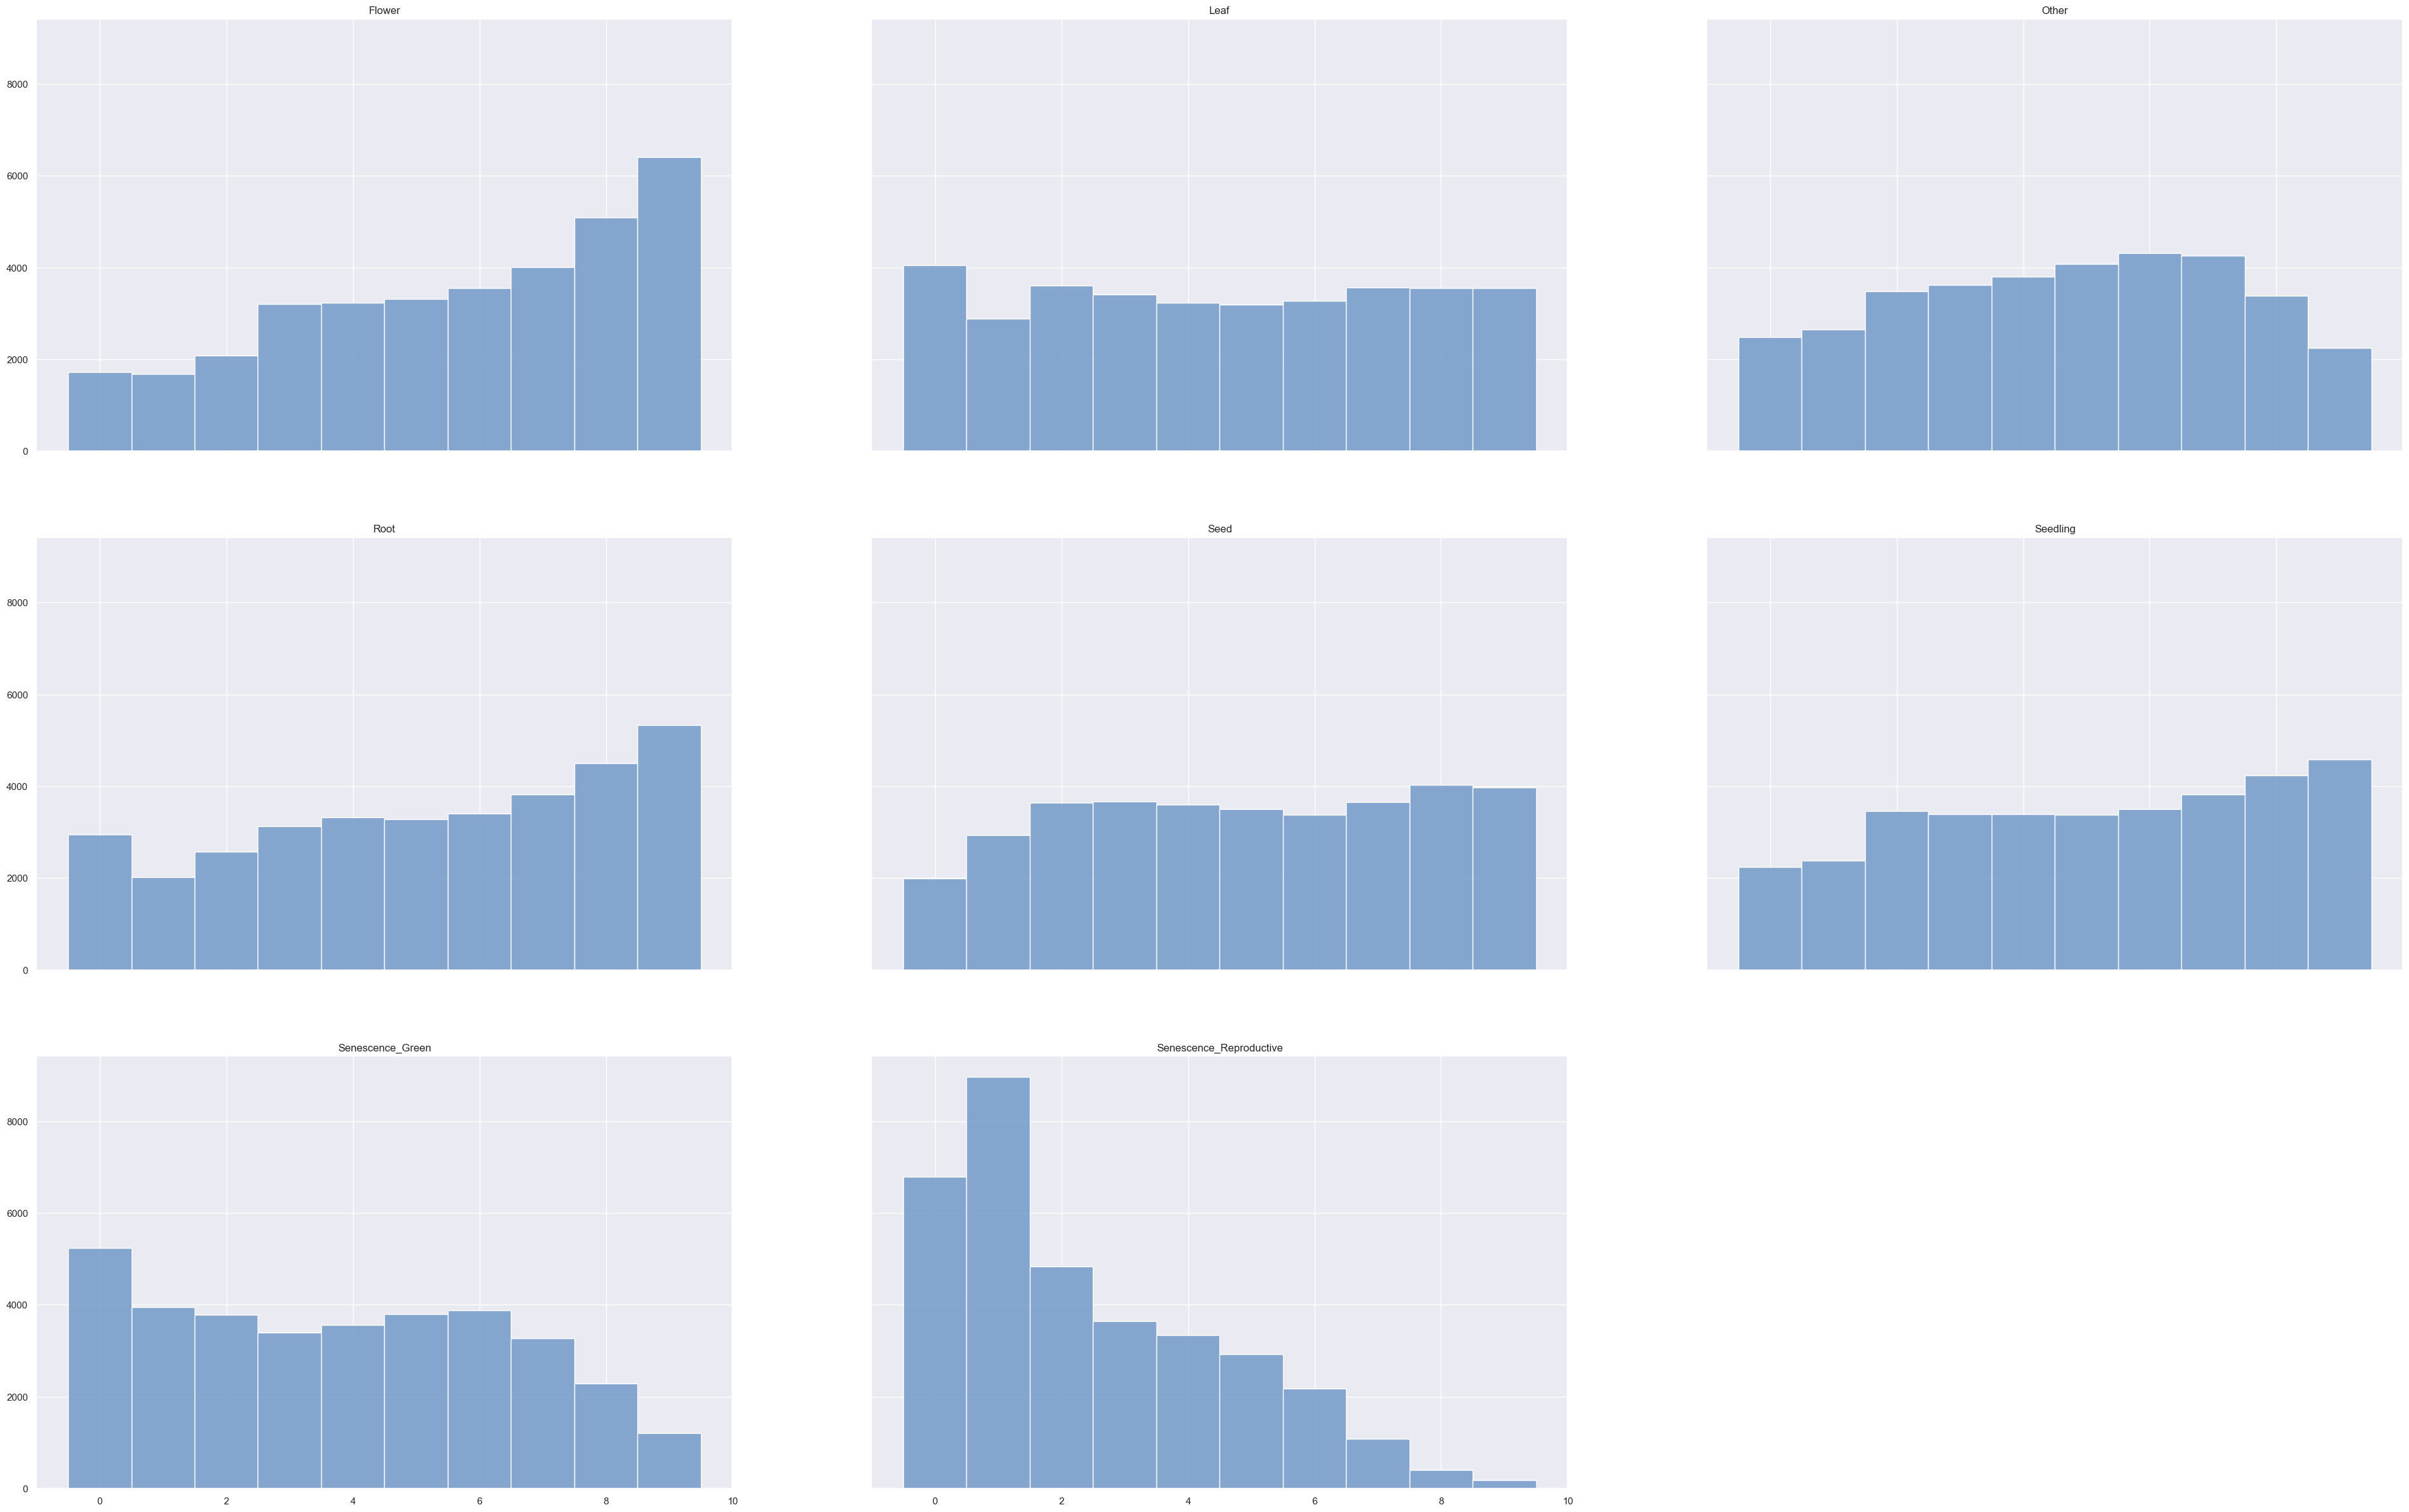

In [13]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-mean')
)

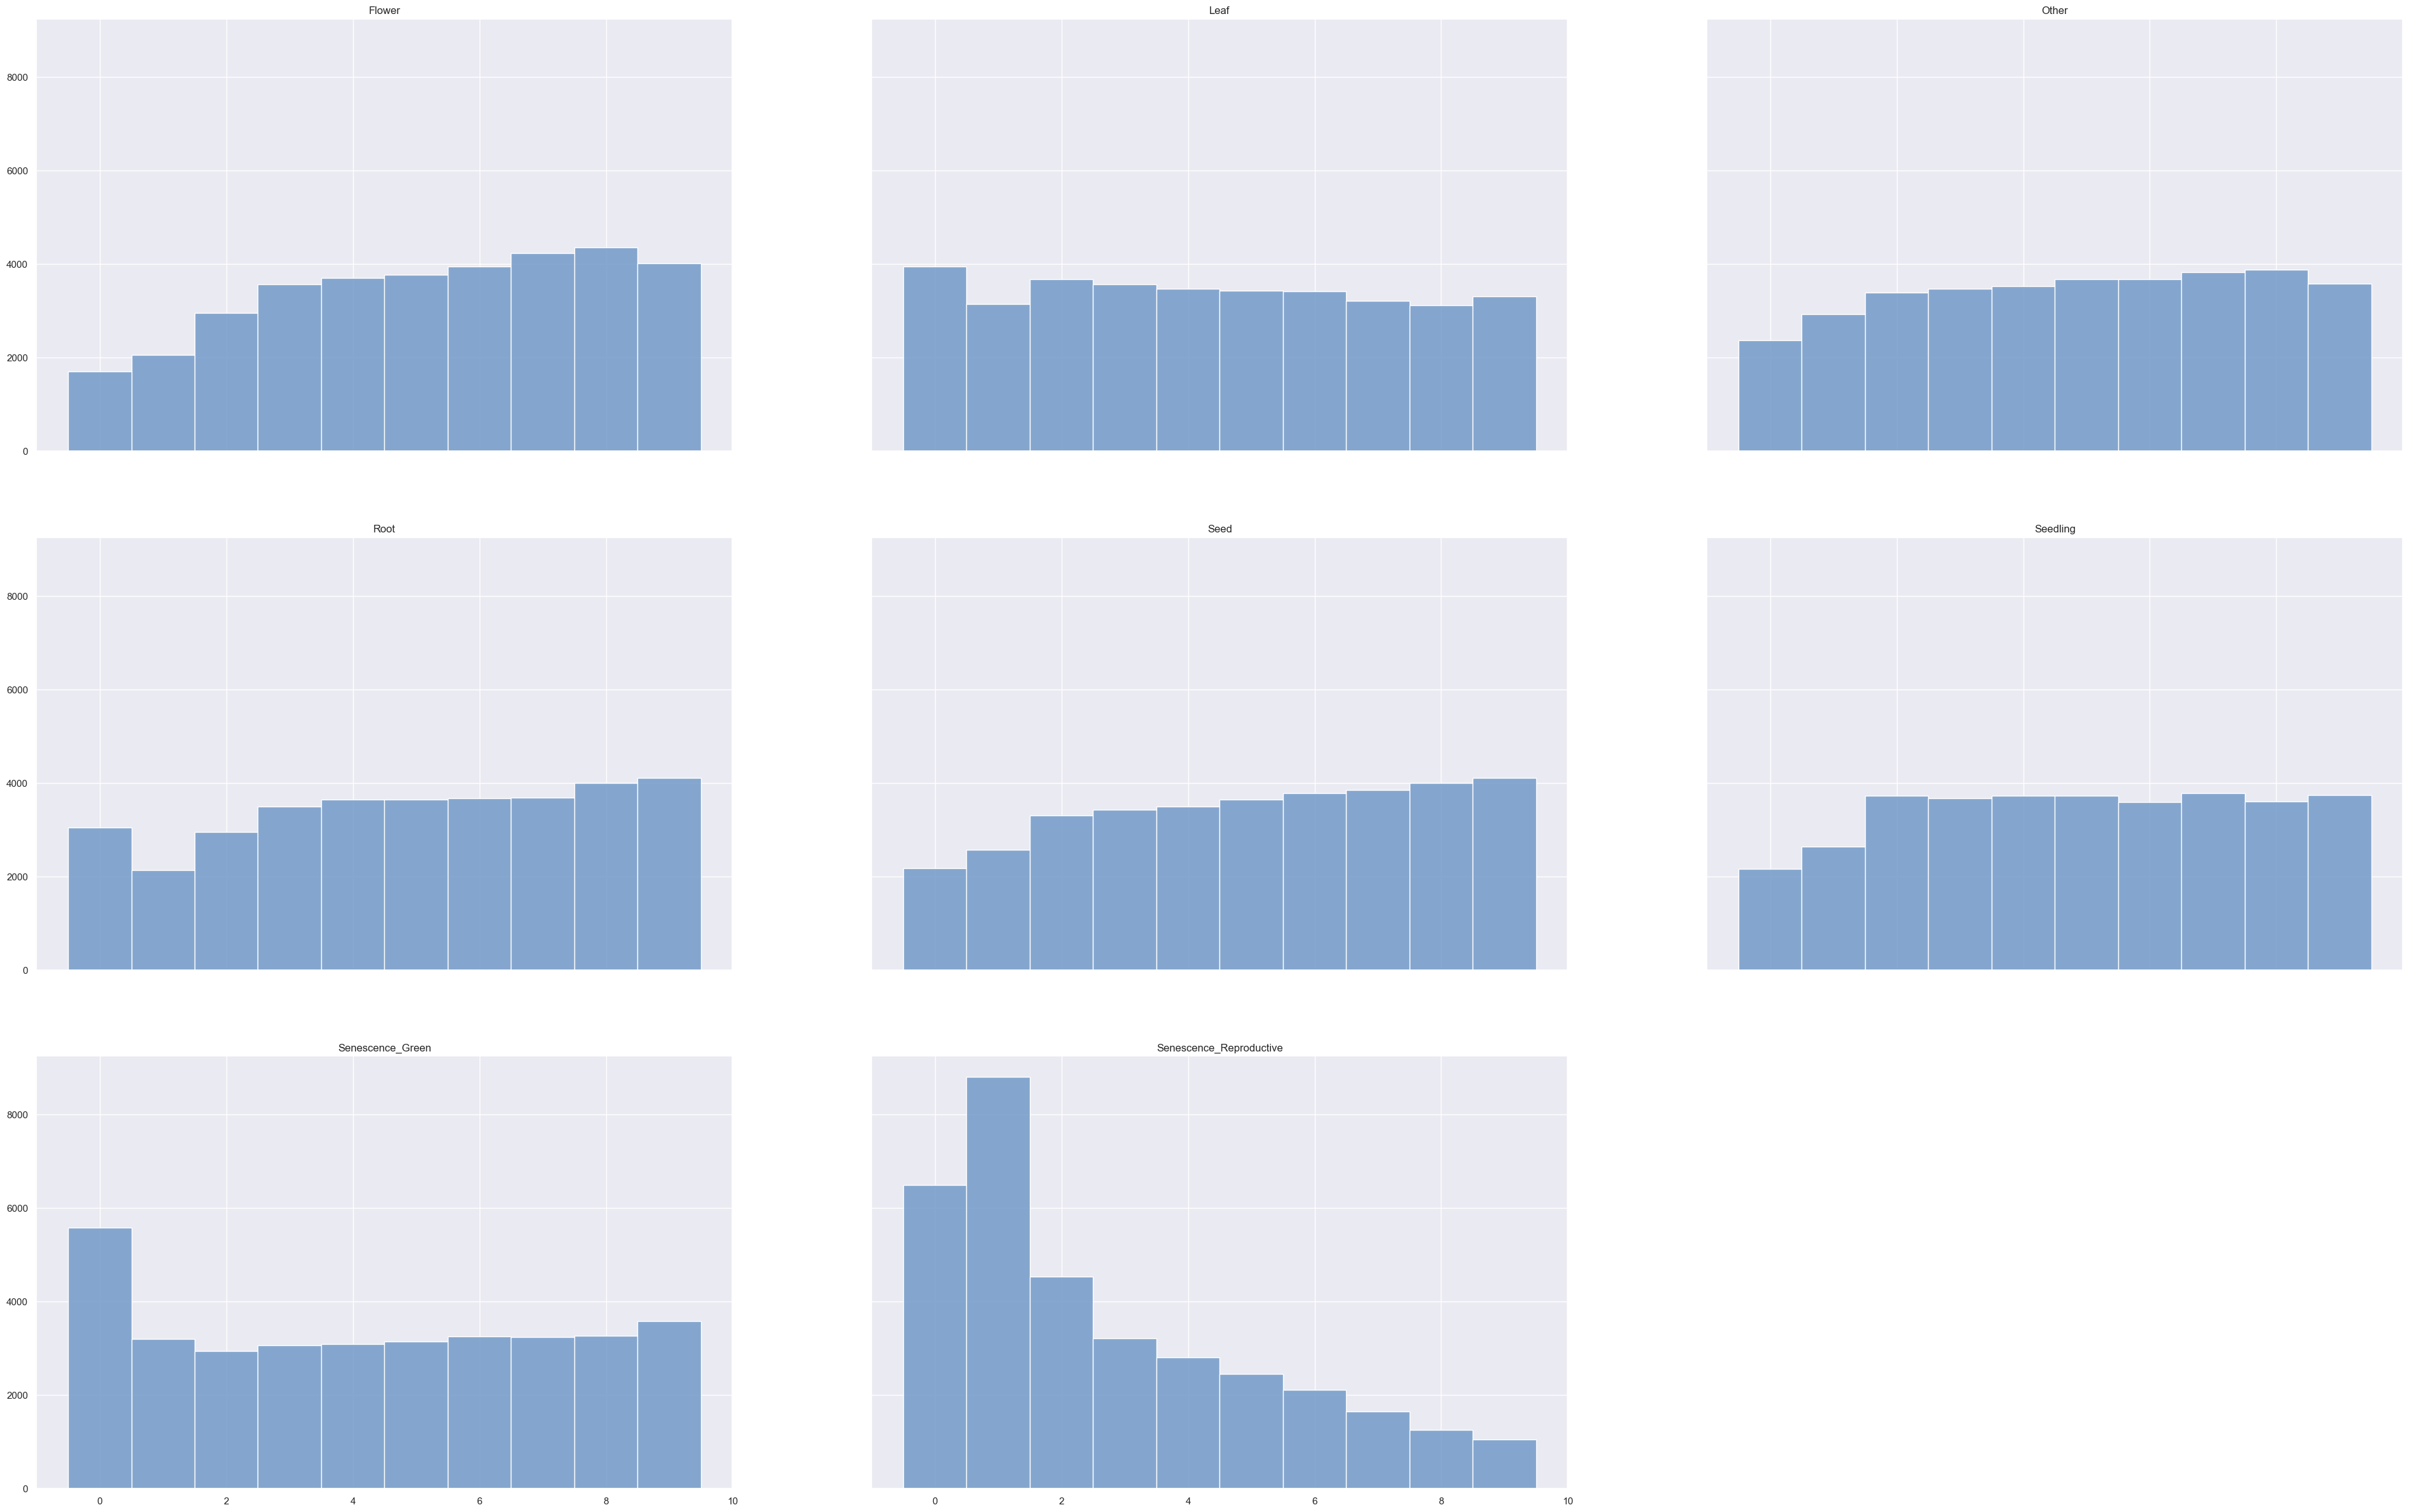

In [14]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'p80',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-p80')
)

## 3.2 Save

In [15]:
# Save the target transcript classification

data_writer.write_json(
	data     = labels,
	filename = os.path.join(OUT_DATA, 'target-labels.json')
)